In [ ]:
import os
from PIL import Image
import numpy as np
import json
import random
import torch

In [ ]:
class ARC_Task:
  def __init__(self, inputs, outputs, test_input, test_output):
    self.inputs = inputs
    self.outputs = outputs
    self.test_input = test_input
    self.test_output = test_output

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline

def collapse(tensor):
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      arr[x, y] = torch.argmax(tensor[x, y]).item()
  return arr

def visualize(tensor):
  #torch.argmax(tensor.reshape(30, 30, 11)).item()
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      arr[x, y] = torch.argmax(tensor[x, y]).item()
  convert(arr)

def visualize2(tensor):
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      difs = [torch.abs(v - tensor[x, y]) for v in color2vector]
      sums = [torch.sum(difs[i]) for i in range(11)]
      index_min = min(range(len(sums)), key=sums.__getitem__)
      #print(index_min)
      arr[x, y] = index_min
  convert(arr)

converter = {}
converter[0] = np.array([0, 0, 0])
converter[1] = np.array([0, 116, 217])
converter[2] = np.array([255, 65, 54])
converter[3] = np.array([46, 204, 64])
converter[4] = np.array([255, 220, 0])
converter[5] = np.array([170, 170, 170])
converter[6] = np.array([240, 18, 190])
converter[7] = np.array([255, 113, 27])
converter[8] = np.array([127, 219, 255])
converter[9] = np.array([135, 12, 37])
converter[10] = np.array([255, 255, 255])

def convert(X):
  Y = np.zeros(shape=(X.shape[0], X.shape[1], 3), dtype=np.uint8)
  for x in range(X.shape[0]):
    for y in range(X.shape[1]):
      Y[x, y] = converter[X[x, y]]
  imshow(Y)

In [ ]:
def fetch(directory):
  data = []
  MAX_LENGTH = 30
  os.chdir(directory)
  files = [f for f in os.listdir() if f.endswith('json')]
  for f in files:
    with open(f, 'r') as file:
      json_file = json.loads(file.read())
      inputs = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['train']]
      outputs = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['train']]
      test_input = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['test']]
      test_output = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['test']]
      data.append(ARC_Task(inputs, outputs, test_input[0], test_output[0]))

  return data

def one_hot_encode(array):
  MAX_LENGTH = 30
  arr = torch.zeros((MAX_LENGTH, MAX_LENGTH, 11))
  size = array.shape
  for x in range(MAX_LENGTH):
    for y in range(MAX_LENGTH):
      if x < size[0] and y < size[1]:
        arr[x, y, array[x, y]] = 1
      else:
        arr[x, y, 10] = 1
  return arr.flatten()

In [ ]:
from torch.utils.data import Dataset

class ARCDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __getitem__(self, idx):
    return self.data[idx]

  def __len__(self):
    return len(self.data)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):

  def __init__(self, input_shape=30*30*11, latent_dim = 128):
    super().__init__()
    self.input_shape = input_shape
    self.latent_dim = latent_dim
    self.encoder_l1 = nn.Linear(self.input_shape, self.latent_dim, bias=True)
    #self.drop1 = nn.Dropout(0.25)
    self.encoder_l2 = nn.Linear(self.latent_dim, self.latent_dim, bias=True)
    self.decoder_l1 = nn.Linear(self.latent_dim, self.latent_dim, bias=True)
    #self.drop2 = nn.Dropout(0.25)
    self.decoder_l2 = nn.Linear(self.latent_dim, self.input_shape, bias=True)

  def forward(self, task):
    task_vector = torch.zeros(self.latent_dim).cuda()
    for input, output in zip(task.inputs, task.outputs):
      latent_input = self.run_encoder(input)
      latent_output = self.run_encoder(output)
      task_vector += latent_output - latent_input
    task_vector /= len(task.inputs)
    latent_prediction = self.run_encoder(task.test_input) + task_vector
    prediction = self.run_decoder(latent_prediction)
    return prediction

  def run_encoder(self, x):
    output = F.sigmoid(self.encoder_l1(x.cuda()))
    latent = F.sigmoid(self.encoder_l2(output))
    return latent

  def run_decoder(self, latent):
    output = F.sigmoid(self.decoder_l1(latent))
    x_hat = F.sigmoid(self.decoder_l2(output))
    return x_hat

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DeepAutoencoder(nn.Module):

  def __init__(self, input_shape=30*30*11):
    super().__init__()
    self.input_shape = input_shape
    self.latent_dim = 128

    self.encoder_l1 = nn.Linear(self.input_shape, 500, bias=True)
    self.drop1 = nn.Dropout(0.25)

    self.encoder_l2 = nn.Linear(500, 128, bias=True)
    self.drop2 = nn.Dropout(0.25)

    self.encoder_l3 = nn.Linear(128, 128, bias=True)
    self.drop3 = nn.Dropout(0.25)

    self.encoder_l4 = nn.Linear(128, 128, bias=True)

    self.decoder_l1 = nn.Linear(128, 128, bias=True)
    self.drop4 = nn.Dropout(0.25)

    self.decoder_l2 = nn.Linear(128, 128, bias=True)
    self.drop5 = nn.Dropout(0.25)

    self.decoder_l3 = nn.Linear(128, 500, bias=True)
    self.drop6 = nn.Dropout(0.25)

    self.decoder_l4 = nn.Linear(500, self.input_shape, bias=True)

  def forward(self, task):
    task_vector = torch.zeros(self.latent_dim).cuda()
    for input, output in zip(task.inputs, task.outputs):
      latent_input = self.run_encoder(input)
      latent_output = self.run_encoder(output)
      task_vector += latent_output - latent_input
    task_vector /= len(task.inputs)
    latent_prediction = self.run_encoder(task.test_input) + task_vector
    prediction = self.run_decoder(latent_prediction)
    return prediction

  def run_encoder(self, x):
    output = self.drop1(F.sigmoid(self.encoder_l1(x.cuda())))
    output = self.drop2(F.sigmoid(self.encoder_l2(output)))
    output = self.drop3(F.sigmoid(self.encoder_l3(output)))
    latent = F.sigmoid(self.encoder_l4(output))
    return latent

  def run_decoder(self, latent):
    output = self.drop4(F.sigmoid(self.decoder_l1(latent)))
    output = self.drop5(F.sigmoid(self.decoder_l2(output)))
    output = self.drop6(F.sigmoid(self.decoder_l3(output)))
    x_hat = F.sigmoid(self.decoder_l4(output))
    return x_hat

In [ ]:
train_dataset = ARCDataset(fetch("/content/train"))
len(train_dataset)

400

In [ ]:
model = Autoencoder(latent_dim=500)
model.train()
model.cuda()

Autoencoder(
  (encoder_l1): Linear(in_features=9900, out_features=500, bias=True)
  (encoder_l2): Linear(in_features=500, out_features=500, bias=True)
  (decoder_l1): Linear(in_features=500, out_features=500, bias=True)
  (decoder_l2): Linear(in_features=500, out_features=9900, bias=True)
)

In [ ]:
import torch.optim as optim

mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 200

for epoch in range(n_epochs):
  loss = 0

  for task in train_dataset:
    optimizer.zero_grad()
    prediction = model(task)
    train_loss = mse(prediction, task.test_output.cuda())
    train_loss.backward()
    optimizer.step()
    loss += train_loss.item()

  if epoch % 5 == 0:
    print(epoch, loss)

0 0.28301404739059066
5 0.28293163298150503
10 0.2845041593242499
15 0.28261351495621767
20 0.28248673598841734
25 0.2822847746119663
30 0.28196888797247865
35 0.2818436294043174
40 0.28343109873097205
45 0.28157900785265255
50 0.2814579003438382
55 0.28135839750638425
60 0.2813317726755251
65 0.2812523334259147
70 0.2812198045595977
75 0.2811987276804686
80 0.281126718005936
85 0.280964672724739
90 0.28090986064867707
95 0.2808715585224846
100 0.2938435014037566
105 0.28055453926833707
110 0.28045619443342673
115 0.28033254569646004
120 0.28021685753490644
125 0.28007704155531954
130 0.27988598032042944
135 0.2797252271472246
140 0.2796120084094298
145 0.27957127647817615
150 0.2795215636034065
155 0.2794444148443489
160 0.27935524794321864
165 0.27933336906864525
170 0.279347774797273
175 0.2792520701067218
180 0.27922813405206526
185 0.2792143317301097
190 0.27920400012428104
195 0.27916846286017005


In [ ]:
# Compute matches
correct = 0
for task in train_dataset:
    prediction = model(task)
    if np.array_equal(collapse(prediction.reshape(30, 30, 11)), collapse(task.test_output.reshape(30, 30, 11))):
      correct += 1

print(correct)

109


In [ ]:
# Compute MSE score
total_loss = 0
for task in test_dataset:
    prediction = model(task)
    train_loss = mse(prediction, task.test_output.cuda())
    total_loss += train_loss.item()
print(total_loss)

12.132727607677225


In [ ]:
test_dataset = ARCDataset(fetch("/content/test"))
len(test_dataset)

400

In [ ]:
a = 106

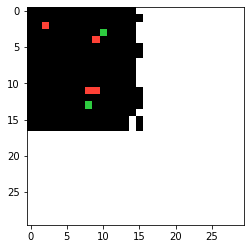

In [ ]:
p = model.forward(test_dataset[a])
visualize(p.reshape(30, 30, 11))

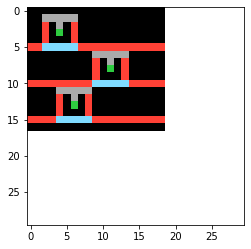

In [ ]:
visualize(test_dataset[a].test_output.reshape(30, 30, 11))